In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
###############################################################################
# Figure configuration
import matplotlib as mpl
plt.rcParams['figure.figsize'] = (16, 6)

###############################################################################
# Load and Define dataset:
start_date = datetime(2020,1,1)
end_date = datetime(2023,10,31)
DATA_raw = pd.read_csv('META_FeatureMart.csv', index_col = [0])
DATA_raw.describe()

# copy the data
DATA = DATA_raw.copy() 
# NORMALIZATION
for column in DATA_raw.columns[1:]:
    if column != 'META_ADJ CLOSE':
        DATA[column] = (DATA_raw[column] -
                               DATA_raw[column].mean()) / DATA_raw[column].std()  

In [3]:
DATA_raw.head()

,DATE,MKT-RF,SMB,HML,RMW,CMA,RF,ADS_INDEX,SP500,T10Y3M,...,USRECDM,USRECDP,META_OPEN,META_HIGH,META_LOW,META_CLOSE,META_ADJ CLOSE,META_VOLUME,META_DAILY_RETURN,META_RSI
0,1/3/2017,0.53,-0.24,0.33,-0.28,0.11,0.0,0.199210,2257.83,1.92,...,0,0,116.029999,117.839996,115.510002,116.860001,116.860001,20663900,NaN,NaN
1,1/4/2017,1.03,0.51,0.29,-0.37,-0.10,0.0,0.178190,2270.75,1.93,...,0,0,117.550003,119.660004,117.290001,118.690002,118.690002,19630900,0.015660,NaN
2,1/5/2017,0.50,0.02,-0.36,0.02,-0.15,0.0,0.157624,2269.00,1.85,...,0,0,118.860001,120.949997,118.320000,120.669998,120.669998,19492200,0.016682,NaN
3,1/6/2017,-0.24,-0.52,-0.49,-0.06,-0.16,0.0,0.137503,2276.98,1.89,...,0,0,120.980003,123.879997,120.029999,123.410004,123.410004,28545300,0.022707,NaN
4,1/9/2017,-0.11,0.04,-0.61,0.32,-0.34,0.0,0.079457,2268.90,1.88,...,0,0,123.550003,125.430000,123.040001,124.900002,124.900002,22880400,0.012074,NaN


In [4]:
###############################################################################
# Define X and Y:
DATA.columns
columns_to_drop = ['DATE', 'META_OPEN', 'META_HIGH', 'META_LOW', 'META_CLOSE', 'META_ADJ CLOSE', 'META_DAILY_RETURN']

# Drop the specified columns
X = DATA.drop(columns=columns_to_drop)
X = X.fillna(method='bfill')

y = DATA['META_ADJ CLOSE']

# Data Issues:
missing_values = X.isnull().sum()
X['DCPF1M'].fillna(method='ffill', inplace=True)

In [5]:
# define the model
model = RandomForestRegressor(bootstrap=True, criterion='squared_error', max_depth=None,\
           max_features='auto', max_leaf_nodes=None,\
           min_impurity_decrease=0.0,\
           min_samples_leaf=1, min_samples_split=2,\
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,\
           oob_score=False, random_state=None, verbose=0, warm_start=False)

# fit the model
model.fit(X, y)

RandomForestRegressor()

                Feature Importance
DCPN3M                3.824983e-01
CBBTCUSD              2.386028e-01
SP500                 5.813111e-02
AMERIBOR              5.414353e-02
OBMMIJUMBO30YF        4.538885e-02
BAMLH0A0HYM2          3.968614e-02
RIFSPPFAAD90NB        3.299138e-02
DCPF1M                2.315171e-02
DHHNGSP               1.990652e-02
DAAA                  1.990215e-02
DCOILBRENTEU          1.427357e-02
NIKKEI225             1.052801e-02
DEXUSUK               8.060463e-03
META_RSI              6.781288e-03
DEXUSEU               6.332836e-03
CBETHUSD              6.177128e-03
DGS1                  5.356665e-03
DBAA                  5.268147e-03
DCOILWTICO            4.779029e-03
ADS_INDEX             3.925112e-03
T10YIE_Y              2.455437e-03
T10YIE_X              2.270023e-03
BAMLH0A0HYM2EY        2.016459e-03
T10Y3M                1.991313e-03
DGS10                 1.511753e-03
DEXJPUS               9.736341e-04
VIXCLS                9.214693e-04
T5YIE               

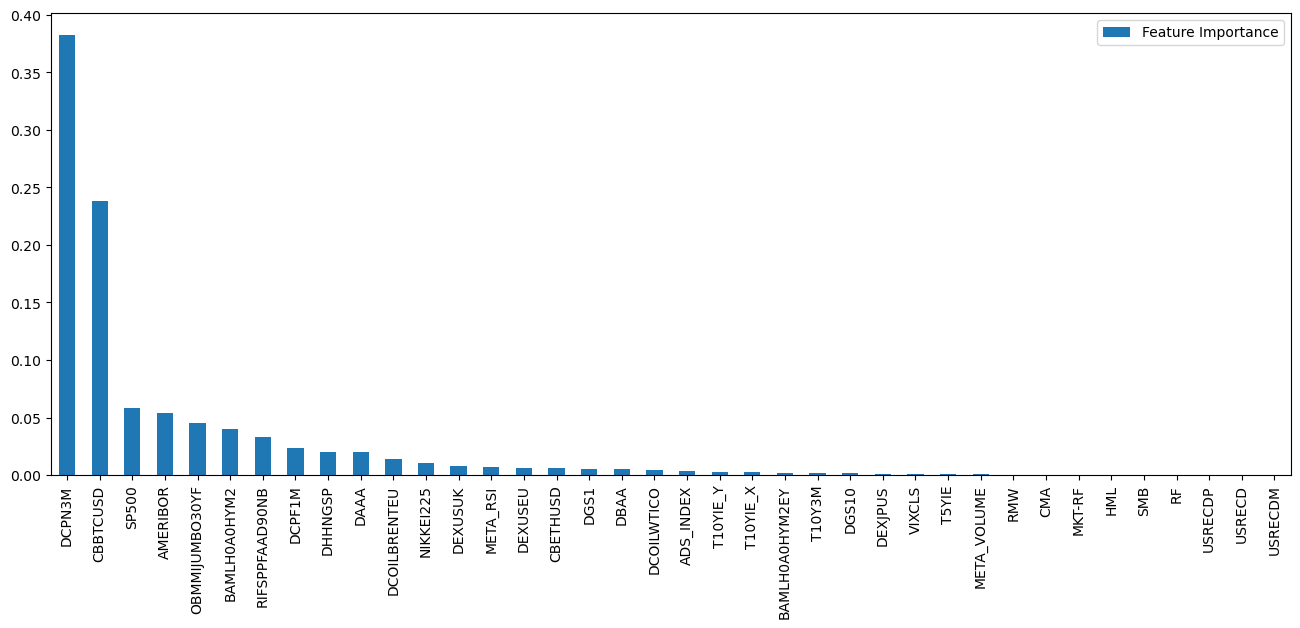

In [6]:
###############################################################################
# Feature Importance:
# 1. average feature importance
df_feature_importance = pd.DataFrame(model.feature_importances_, index=X.columns, \
                                     columns=['Feature Importance']).sort_values('Feature Importance', ascending=False)
print(df_feature_importance)
print(df_feature_importance.count())


# 2. all feature importance for each tree
# (1) bar chart
df_feature_importance.plot(kind='bar');

In [7]:
###############################################################################
# Feature Selection:
# Assuming feature_importance is your array of feature importance scores
feature_threshold = 0.025  # Adjust the threshold based on your preference
df_new_feature = df_feature_importance[df_feature_importance['Feature Importance'] > feature_threshold]

# Get the selected features
selected_features = df_new_feature.index
print(f'Selected Features: {selected_features.to_list()}')
X_selected = X[selected_features]

Selected Features: ['DCPN3M', 'CBBTCUSD', 'SP500', 'AMERIBOR', 'OBMMIJUMBO30YF', 'BAMLH0A0HYM2', 'RIFSPPFAAD90NB']


In [8]:
#=========================================================================
# exhaustively search for the optimal hyperparameters
#=========================================================================
from sklearn.model_selection import GridSearchCV
# set up our search grid
# Define the parameter grid to search
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize the Random Forest Regressor
regressor = RandomForestRegressor(random_state=42)
# Initialize GridSearchCV
search = GridSearchCV(regressor, param_grid, cv=5).fit(X, y)

print("The best hyperparameters are ",search.best_params_)
regressor = RandomForestRegressor(n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           min_samples_split = search.best_params_["min_samples_split"],
                           min_samples_leaf = search.best_params_["min_samples_leaf"],)

regressor.fit(X, y)


The best hyperparameters are  {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


RandomForestRegressor(min_samples_leaf=2)

In [9]:
#=========================================================================
# To use early_stopping_rounds: 
# "Validation metric needs to improve at least once in every 
# early_stopping_rounds round(s) to continue training."
#=========================================================================
# first perform a test/train split 
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X_selected,y, test_size = 0.2)
regressor.fit(X_train, y_train)

#=========================================================================
# use the model to predict the prices for the test data
#=========================================================================
y_hat = regressor.predict(X_test)

In [10]:
###############################################################################
# Cross Validation:
# Perform cross-validation
cv_scores = cross_val_score(regressor, X, y, cv=5, scoring='neg_mean_squared_error')

# Let's get the mean score
mean_cv_score = np.mean(cv_scores)

# Get feature importances
feature_importances = model.feature_importances_

# Print the results
print("Mean Cross-Validation Score:", mean_cv_score)
print("Feature Importances:", feature_importances)

# Evaluate Model:
# Calculate the mean squared error and convert it back to positive
mse_scores = -cv_scores
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

rmse = np.mean(np.sqrt(np.abs(cv_scores)))
std_rmse = np.std(np.sqrt(np.abs(cv_scores)))
print('---------------------------------------','\n')
print(f'MEAN of Mean Squared Error: {mean_mse}')
print('---------------------------------------','\n')
print(f'STD of RMSE Squared Error: {std_rmse}')
print('---------------------------------------','\n')
print(f'Root Mean Squared Error on Test Set: {rmse}')
print('---------------------------------------','\n')

Mean Cross-Validation Score: -2839.8614691887497
Feature Importances: [1.40045097e-04 1.07535900e-04 1.22414481e-04 1.65418689e-04
 1.60192319e-04 9.62765409e-06 3.92511237e-03 5.81311080e-02
 1.99131294e-03 4.53888490e-02 6.33283587e-03 9.73634092e-04
 8.06046250e-03 2.38602825e-01 6.17712813e-03 2.27002255e-03
 1.42735653e-02 9.21469283e-04 1.99021457e-02 5.26814671e-03
 1.05280090e-02 5.41435265e-02 2.45543739e-03 7.32413880e-04
 3.96861392e-02 2.01645879e-03 1.51175337e-03 5.35666451e-03
 3.29913803e-02 3.82498257e-01 2.31517074e-02 4.77902878e-03
 1.99065213e-02 1.15976319e-06 1.39184043e-07 7.03826198e-06
 5.29225614e-04 6.78128833e-03]
--------------------------------------- 

MEAN of Mean Squared Error: 2839.8614691887497
--------------------------------------- 

STD of RMSE Squared Error: 22.9404275834772
--------------------------------------- 

Root Mean Squared Error on Test Set: 48.09987787381573
--------------------------------------- 



In [11]:
y_test

268     190.000000
605     177.470001
598     184.820007
1551    185.250000
1191    353.579987
           ...    
280     173.149994
951     276.140015
1196    326.230011
312     155.389999
403     183.089996
Name: META_ADJ CLOSE, Length: 344, dtype: float64

In [12]:
## There is no overfitting given the STD of RMSE is smaller than RMSE

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_hat)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(rmse)

6.5864433837848555


## Trading Rules

In [19]:
### Creating input data for month of October 2023
new_X = X_selected[-66:]
new_y_test = y[-66:]

In [20]:
### Predicting using XGBoost
y_pred = regressor.predict(new_X)

In [21]:
import numpy as np

def TRADING_RULE(P_hat, P, options):
    if options == 'BUY HOLD':
        return TRADING_RULE_1(P)
    elif options == 'LONG SHORT':
        return TRADING_RULE_2(P_hat, P)
    elif options == 'DAY TRADE':
        return TRADING_RULE_3(P_hat, P)

def TRADING_RULE_1(P):
    T = P.shape[0]
    signal = np.zeros(T)
    signal[0] = 1
    signal[-1] = -1
    return signal

def TRADING_RULE_2(P_hat, P):
    T = P.shape[0]
    signal = np.zeros(T)
    for t in range(1, T):
        if (P_hat[t-1] > P[t-1]) + (P_hat[t] < P[t]) == 2:  # FORCAST > OPEN: LONG
            signal[t] = 1
        elif (P_hat[t-1] < P[t-1]) + (P_hat[t] > P[t]) == 2:  # FORECAST < OPEN: SHORT
            signal[t] = -1
    return signal

def TRADING_RULE_3(P_hat, P):
    T = P.shape[0]
    signal = np.zeros(T)
    for t in range(1, T):
        if P_hat[t] > P[t]:  # FORCAST > OPEN: LONG
            signal[t] = 1
        elif P_hat[t] < P[t]:  # FORECAST < OPEN: SHORT
            signal[t] = -1
    return signal

In [25]:
import numpy as np

def calculate_profit_loss(signal, price):
    T = len(signal)
    position = np.zeros(T)
    balance = np.zeros(T)
    position[1:] = np.diff(signal)  # Buy (1) or Sell (-1) at each signal change
    balance[0] = 10000  # Initial balance
    for t in range(1, T):
        balance[t] = balance[t - 1] + position[t] * price[t]
    return balance

# Example usage:
# Assume 'price' is a numpy array or list containing the asset prices over time
# and 'signal' is the trading signal generated by TRADING_RULE function.

# Example price data
price = new_y_test.values

# Example trading signal
signal = TRADING_RULE(y_pred, new_y_test.values, 'DAY TRADE')

# Calculate profit and loss
profit_loss = calculate_profit_loss(signal, price)

# Display the results
print("Trading Signal:", signal)
print("Asset Prices:", price)
print("Profit and Loss:", profit_loss)

Trading Signal: [ 0. -1.  1.  1.  1. -1. -1.  1.  1. -1.  1. -1. -1.  1.  1. -1. -1. -1.
  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1. -1. -1.  1.  1.  1.
 -1.  1. -1. -1. -1.  1.  1.  1. -1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1.  1.  1.  1. -1.  1.]
Asset Prices: [318.6000061 322.7099915 314.3099976 313.1900024 310.730011  316.5599976
 312.6400146 305.2099915 305.7399902 301.6400146 306.1900024 301.9500122
 294.2900085 285.0899963 283.25      289.8999939 287.6000061 294.2399902
 286.75      285.5       290.2600098 297.9899902 295.1000061 295.8900146
 296.3800049 300.1499939 299.1700134 298.6700134 297.8900146 307.5599976
 301.6600037 305.0599976 311.7200012 300.3099976 302.5499878 305.0700073
 299.6700134 295.730011  299.0799866 300.8299866 298.9599915 297.7399902
 303.9599915 300.2099915 306.8200073 300.9400024 305.5799866 304.7900085
 315.4299927 318.3599854 321.8399963 327.8200073 324.1600037 314.6900024
 321.1499939 324.        316.9700012 312.809

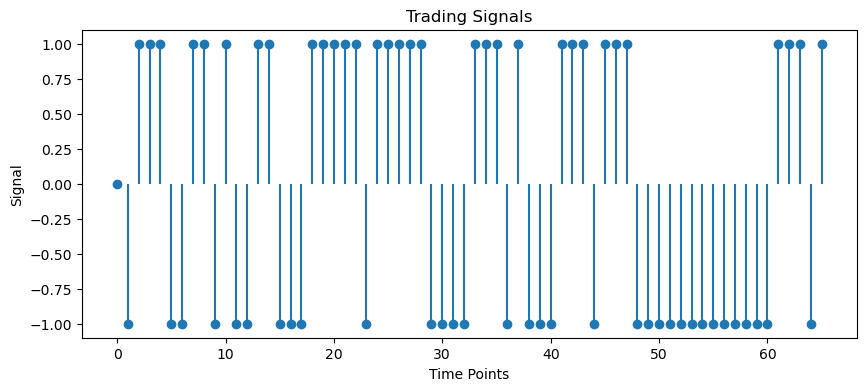

In [26]:
import matplotlib.pyplot as plt
import numpy as np


trading_signals = signal

time_points = np.arange(len(trading_signals))

# Plot the trading signals
plt.figure(figsize=(10, 4))
plt.stem(time_points, trading_signals, basefmt=" ", markerfmt="o", linefmt="-")
plt.title('Trading Signals')
plt.xlabel('Time Points')
plt.ylabel('Signal')
plt.show()

In [27]:
Total_Profit = profit_loss[-1] - profit_loss[0]
print(str(np.round(Total_Profit)) + ' USD')

182.0 USD


In [33]:
import yfinance as yf

# Define the ticker symbol and time period
ticker_symbol = "META"
period = "90d"

# Fetch data from Yahoo Finance
stock_data = yf.Ticker(ticker_symbol)
df = stock_data.history(period=period).reset_index()
 
import plotly.graph_objects as go

# Create a Plotly graph
fig = go.Figure(data=[go.Scatter(x=df['Date'], y=df['Close'], mode='lines', name='META')])
fig.update_layout(title='Simulated META Stock Price for the Past 90 Days',
                  xaxis_title='Date',
                  yaxis_title='Price (USD)',
                  template="plotly_dark")
fig.show()

df.head()


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2023-08-08 00:00:00-04:00,314.399994,317.890015,310.109985,312.640015,15183500,0.0,0.0
1,2023-08-09 00:00:00-04:00,312.880005,313.630005,302.850006,305.209991,19955800,0.0,0.0
2,2023-08-10 00:00:00-04:00,307.940002,312.339996,303.869995,305.739990,14358900,0.0,0.0
3,2023-08-11 00:00:00-04:00,302.570007,304.720001,300.359985,301.640015,13967800,0.0,0.0
4,2023-08-14 00:00:00-04:00,300.980011,306.209991,298.250000,306.190002,15641900,0.0,0.0
